In [ ]:
from google.colab import auth
auth.authenticate_user()
from google.cloud import bigquery
import vertexai
import pandas as pd
import pandas_gbq

In [ ]:
PROJECT_ID = "phone_tool"
vertexai.init(project=PROJECT_ID)
TABLE_ID  = "call_recordings.records_transcriptions"
CONVERSATION_LABELS_TABLE_ID = "phone_tool.call_recordings.conversation_label_test"

In [ ]:
def write_df_to_bq(table_id,project_id,df):

  try:
    df.to_gbq(table_id, project_id, if_exists='append')

  except Exception as e:
    print(f"Exception {e} caught while writing to BQ table")

In [ ]:
def get_uris_from_bq(table_id: str,project_id: str) -> list[str]:

    # get uri based on certain length of the audio file
    query = f'''SELECT uri,conversation_duration FROM `phone_tool.call_recordings.call_recordings_metadata`
                where conversation_duration > 120
                and conversation_duration < 600
                order by uri
                limit 3
            '''

    try:
        client = bigquery.Client(project=project_id)
        query_job = client.query(query)

        return [row.uri for row in query_job.result()],[row.conversation_duration for row in query_job.result()]
    except Exception as e:
        print(f"Error fetching processed URIs from BigQuery: {e}")
        return []

In [ ]:
def get_transcripts_from_bq(table_id: str,project_id: str,uri: str) -> list[str]:

    query = f'''select case when speaker = 1 then 'coach' else 'learner' end role
                  , transcript
                FROM `{project_id}.{table_id}`
                where uri = '{uri}'
                and length(transcript) > 0 and confidence > .20
                order by start_time;
            '''
    try:
        client = bigquery.Client(project = project_id)
        query_job = client.query(query)

        return [row.role + " : " + row.transcript for row in query_job.result()]
    except Exception as e:
        print(f"Error fetching processed URIs from BigQuery: {e}")
        return []

In [ ]:
def process_transcripts_gemini10(transcripts_text,prompt,uri):
  from vertexai import generative_models
  model = generative_models.GenerativeModel("gemini-1.0-pro")

  config = {
    "temperature": 0.8,
    "top_p": 1,
    "top_k": 1,
    "max_output_tokens": 2048,
    }

  # Setting all blocks to None refer bug : https://github.com/GoogleCloudPlatform/generative-ai/issues/344
  safety_config = {
        generative_models.HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: generative_models.HarmBlockThreshold.BLOCK_NONE,
        generative_models.HarmCategory.HARM_CATEGORY_HARASSMENT: generative_models.HarmBlockThreshold.BLOCK_NONE,
    }


  '''
  Asking the language model for text classification without giving any labels
  '''
  # responses_ai_labels = model.generate_content(f"Context : {transcripts_text} .Prompt: Generate succinct labels categorizing the main topics and sentiments expressed in the provided transcript of a phone conversation between a university coach and a student. Ensure each label is concise, accurately reflects the content of the conversation, and captures the essence of the exchanges. Limit the length of labels to 1-3 words for clarity and ease of analysis.")
  label_prompt = '''Generate succinct labels categorizing the main topics and sentiments expressed in the provided transcript of a phone conversation between a university coach and a student. The output should be in the following format:
                  Labels: [comma-separated list of 1-3 word labels capturing the main topics]
                  Sentiment: [1-3 word label capturing the overall sentiment]
                  Ensure each label accurately reflects the content of the conversation and captures the essence of the exchanges. The labels should be concise and clear for ease of analysis."
                  '''
  try:
    responses_ai_labels = (model.generate_content(f"Context : {transcripts_text},Prompt : {label_prompt}",generation_config=config,safety_settings=safety_config)).text

  except Exception as e:
    print(f"\tModel could not figure new labels for this uri: {uri} ")
    responses_ai_labels = None

  """
  Checking if the coach has mentioned that the call is being recorded
  """
  try:
    responses_is_phone_recorded = (model.generate_content(f'Context :{transcripts_text} .Prompt: Listen to the provided phone conversation between the university coach and the student. Identify if at any point during the call, the coach notifies the student that the conversation is being recorded. If such a statement is made by the coach, respond with "yes"  If no mention of the call being recorded is found,then respond with "no".',generation_config=config,safety_settings=safety_config)).text
  except Exception as e:
    print(f"\tModel could not figure out if call is being recorded for this uri: {uri} ")
    responses_is_phone_recorded = None

  '''
  Asking the language model for text classification with giving  labels
  '''
  try:
    responses_predefined_labels = (model.generate_content(f"{transcripts_text},{prompt}",generation_config=config,safety_settings=safety_config)).text
  except Exception as e:
    print(f"\tModel could not figure classify conversation for this uri: {uri} ")
    responses_predefined_labels =None

  '''
  Asking the language model for identifying the type of coach
  '''
  try:
    responses_coach = (model.generate_content(f'Context : {transcripts_text} .Prompt: Listen to the provided phone conversation between the university coach and the student. Identify if the coach mentions that they are a success coach respond with "Success coach". If the coach mentions that they are a enrollment coach respond with "Enrollment coach",If the coach did not mention either then respond with "NA"  .',generation_config=config,safety_settings=safety_config)).text
  except Exception as e:
    print(f"\tModel could not identify the coach for this uri: {uri} ")
    responses_coach = None

  '''
  Asking the language model to explain the reason for such output
  '''
  try:
    responses_coach_reason = (model.generate_content(f'Context : {transcripts_text} .Prompt: Listen to the provided phone conversation between the university coach and the student. Identify if the coach mentions that they are a success coach respond with "Success coach" and reason for choosing success coach. If the coach mentions that they are a enrollment coach respond with "Enrollment coach" and reason why you chose enrollment coach,If the coach did not mention either then respond with "NA"  . ',generation_config=config,safety_settings=safety_config)).text
  except Exception as e:
    print(f"\tModel could not reason coach identification for this uri: {uri} ")
    responses_coach_reason = None

  return responses_ai_labels,responses_is_phone_recorded,responses_predefined_labels,responses_coach,responses_coach_reason



In [ ]:
def process_transcripts_gemini15(transcripts_text,prompt,uri):
  from vertexai.preview.generative_models import GenerativeModel

  generative_multimodal_model = GenerativeModel("gemini-1.5-pro-preview-0409")

  '''
  Asking the language model for text classification without giving any labels
  '''

  label_prompt = '''Generate succinct labels categorizing the main topics and sentiments expressed in the provided transcript of a phone conversation between a university coach and a student. The output should be in the following format:
                  Labels: [comma-separated list of 1-3 word labels capturing the main topics]
                  Sentiment: [1-3 word label capturing the overall sentiment]
                  Ensure each label accurately reflects the content of the conversation and captures the essence of the exchanges. The labels should be concise and clear for ease of analysis."
                  '''
  try:
    responses_ai_labels = generative_multimodal_model.generate_content([f"Context : {transcripts_text},Prompt : {label_prompt}"]).text
  except Exception as e:
    print(f"\tModel could not figure new labels for this uri: {uri} ")
    responses_ai_labels = None

  """
  Checking if the coach has mentioned that the call is being recorded
  """
  try:
    responses_is_phone_recorded = generative_multimodal_model.generate_content([f'Context :{transcripts_text} .Prompt: Listen to the provided phone conversation between the university coach and the student. Identify if at any point during the call, the coach notifies the student that the conversation is being recorded. If such a statement is made by the coach, respond with "yes"  If no mention of the call being recorded is found,then respond with "no".']).text
  except Exception as e:
    print(f"\tModel could not figure out if call is being recorded for this uri: {uri} ")
    responses_is_phone_recorded = None

  '''
  Asking the language model for text classification with giving  labels
  '''
  try:
    responses_predefined_labels = generative_multimodal_model.generate_content([f"{transcripts_text},{prompt}"]).text
  except Exception as e:
    print(f"\tModel could not figure classify conversation for this uri: {uri} ")
    responses_predefined_labels =None

  '''
  Asking the language model for identifying the type of coach
  '''
  try:
    responses_coach = generative_multimodal_model.generate_content([f'Context : {transcripts_text} .Prompt: Listen to the provided phone conversation between the university coach and the student. Identify if the coach mentions that they are a success coach respond with "Success coach". If the coach mentions that they are a enrollment coach respond with "Enrollment coach",If the coach did not mention either then respond with "NA"  .']).text
  except Exception as e:
    print(f"\tModel could not identify the coach for this uri: {uri} ")
    responses_coach = None

  '''
  Asking the language model to explain the reason for such output
  '''
  try:
    responses_coach_reason = generative_multimodal_model.generate_content([f'Context : {transcripts_text} .Prompt: Listen to the provided phone conversation between the university coach and the student. Identify if the coach mentions that they are a success coach respond with "Success coach" and reason for choosing success coach. If the coach mentions that they are a enrollment coach respond with "Enrollment coach" and reason why you chose enrollment coach,If the coach did not mention either then respond with "NA"  . ']).text
  except Exception as e:
    print(f"\tModel could not reason coach identification for this uri: {uri} ")
    responses_coach_reason = None

  return responses_ai_labels,responses_is_phone_recorded,responses_predefined_labels,responses_coach,responses_coach_reason



In [ ]:
prompt = ''' Prompt:

You are tasked with analyzing transcripts of phone conversations between a university enrollment coach and a student. Each conversation deals with various aspects of university enrollment, program inquiries, and student concerns. Carefully read each conversation and classify it into the most relevant categories from the list provided. If a conversation touches on multiple topics, select all applicable labels, prioritizing the primary focus.
If none of the labels match return "No Labels match". Respond only with labels

Labels:
Success Coach Advising,
Application assistance,
Financial Hold,
Academic Hold,
GPA,
Change Major,
Probation,
Scholarship,
Military,
Starbucks Partnership,
Transcript,
VISA Issues,
Housing,
Rejection,
Transfer Credits,
Switch to Online Programs,
Transfer to on campus,
Account Issues,
Funding,
Tuition
Below are example conversations. For each, classify the conversation according to the topics discussed.

Example 1:

Learner: "Hello."

Coach: "Hi, this is Bob, coach on recorded line. Is this student?"

Learner: "Yes."

Coach: "Hi student, how are you doing today?"

Learner: "I'm doing alright."

Coach: "Good to hear. I'm calling today because you started an application for our masters program. Let's discuss the program, address your questions, and go over the application process. Do you have any questions?"

Output Format: Application Difficulty


Remember output should not contain any special characters and should only have labels seperated by comma
'''


# print (prompt)

In [ ]:
import re

def clean_yes_no_response(llm_response):
    llm_response = llm_response.lower()

    # Check for explicit affirmative words/phrases
    affirmative_patterns = r"\b(yes|yeah|yup|correct|affirmative|that'?'?s\s*?right)\b"
    if re.search(affirmative_patterns, llm_response):
        return "yes"

    # Check for explicit negative words/phrases
    negative_patterns = r"\b(no|nope|negative|that'?'?s\s*?not\s*?the\s*?case)\b"
    if re.search(negative_patterns, llm_response):
        return "no"

    # Check for explicit negation around affirmative words
    negated_affirmative_patterns = r"\b(not|n'?'?t|never)\s*?(yes|yeah|yup|correct|affirmative|that'?'?s\s*?right)\b"
    if re.search(negated_affirmative_patterns, llm_response):
        return "no"

    # Check for explicit negation around negative words
    negated_negative_patterns = r"\b(not|n'?'?t|never)\s*?(no|nope|negative|that'?'?s\s*?not\s*?the\s*?case)\b"
    if re.search(negated_negative_patterns, llm_response):
        return "yes"

    # If none of the conditions match, return None
    return None

In [ ]:
# loop through all uris and get its results
import time

data_list = []

uris,call_duration_list = get_uris_from_bq(TABLE_ID,PROJECT_ID)
print (f"fetched {len(uris)} uris")

start = time.time()
version = 1.5
index = 0
for uri,duration in zip(uris,call_duration_list):
  print(f"processing {index+1}.",uri)
  index+=1
  data_dict= {}

  transcripts = get_transcripts_from_bq(TABLE_ID,PROJECT_ID,uri)
  transcripts_text = ';'.join(transcripts)
  data_dict["uri"] = uri
  data_dict["duration"] = duration
  if version == 1.0:
    print("Using GEMINI Pro 1.0")
    responses_ai_labels,responses_is_phone_recorded,responses_predefined_labels,responses_coach,responses_coach_reason =  process_transcripts_gemini10(transcripts_text,prompt,uri)
    data_dict["auto_generated_labels"] = responses_ai_labels.split("\n")[0].replace("Labels:","").replace("##","").strip()
    data_dict["is_call_recorded_mentioned"] = clean_yes_no_response(responses_is_phone_recorded)
    data_dict["sentiment"] = responses_ai_labels.split("\n")[1].replace("Sentiment:","").replace("##","").strip()

  if version == 1.5:
    print("Using GEMINI Pro 1.5")
    responses_ai_labels,responses_is_phone_recorded,responses_predefined_labels,responses_coach,responses_coach_reason =  process_transcripts_gemini15(transcripts_text,prompt,uri)
    data_dict["auto_generated_labels"] = responses_ai_labels
    data_dict["sentiment"] = responses_ai_labels
    data_dict["is_call_recorded_mentioned"] = responses_is_phone_recorded


  data_dict["labels"] = responses_predefined_labels


  if responses_coach:
    if "enrollment" in responses_coach.lower():
      data_dict["coach"] = "enrollment coach"

    else:
      data_dict["coach"] = "success coach"
  else:
    data_dict["coach"] = None

  if responses_coach_reason:
    data_dict["responses_coach_reason"] = responses_coach_reason
  else:
    data_dict["responses_coach_reason"] = None


  data_list.append(data_dict)
  print()
end = time.time()
print(f"Finished in {end-start} seconds")
  # break

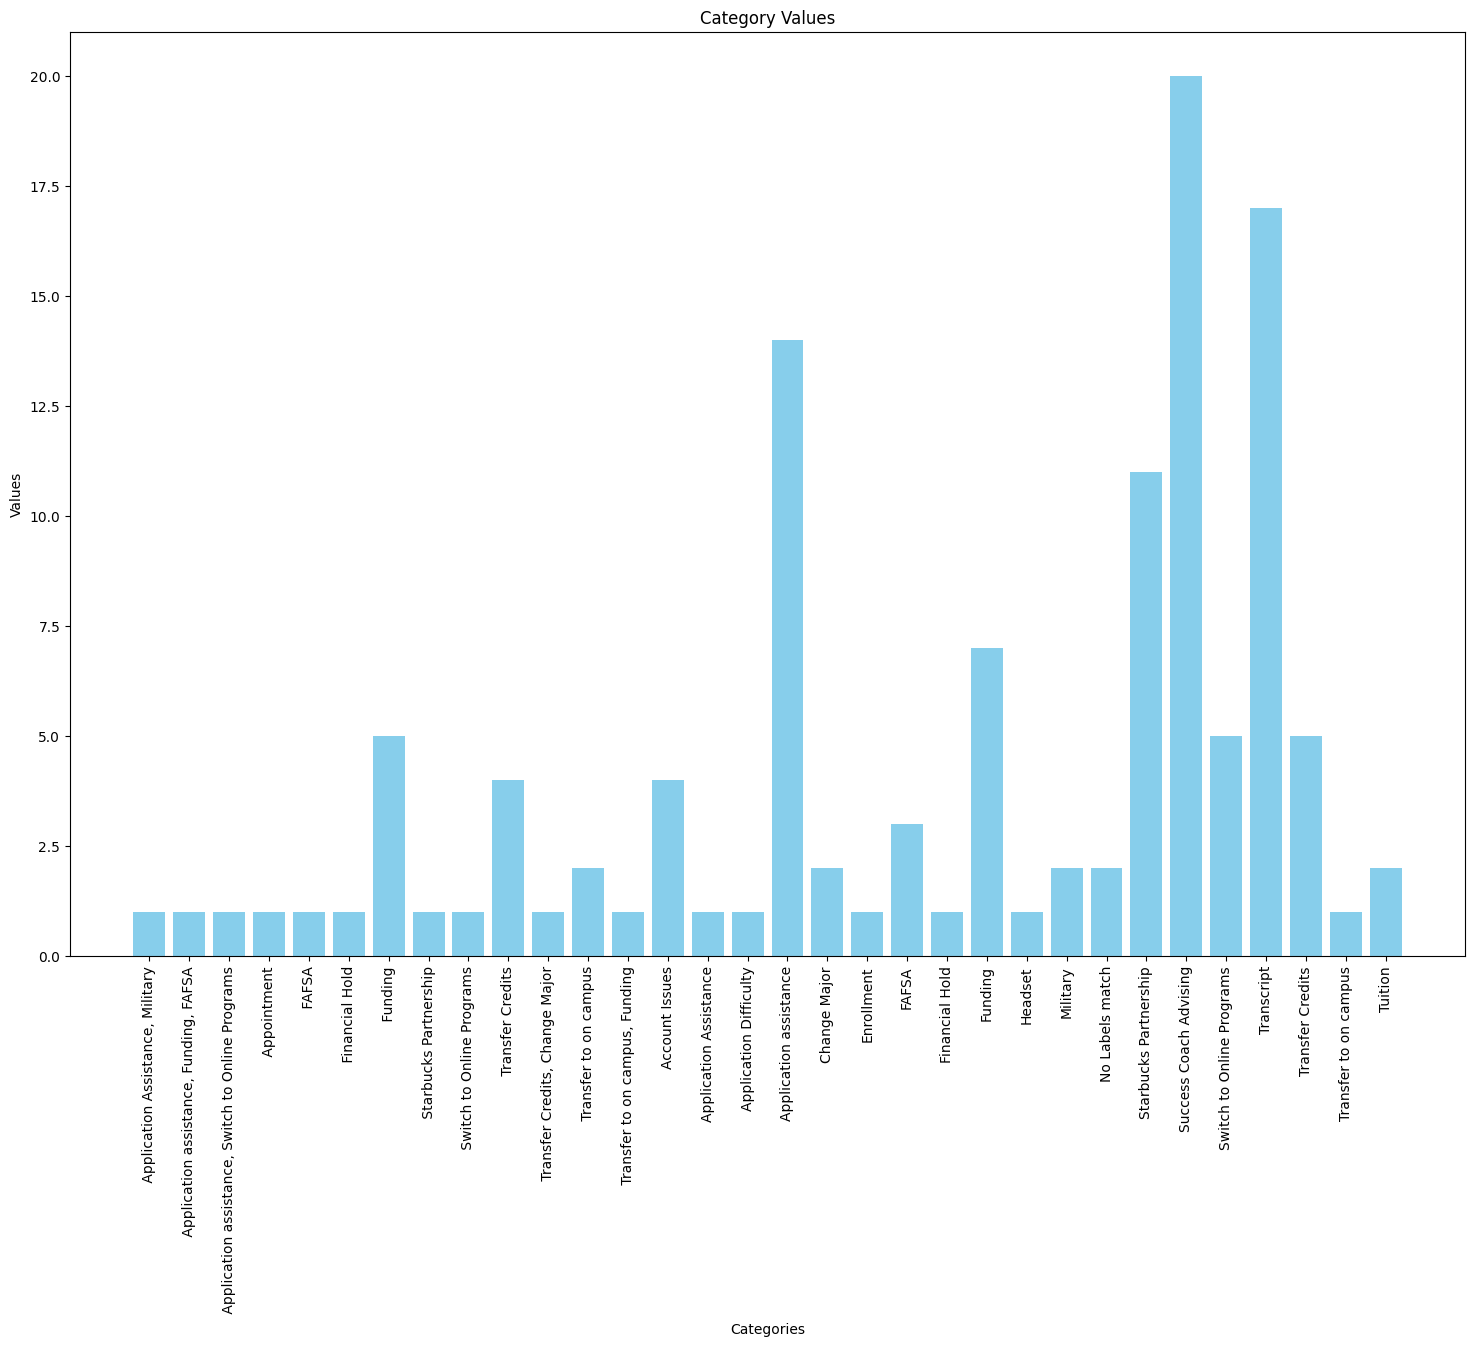

In [ ]:
'''
Table storing the frequency of labels sorted in descending order of the frequency.

'''
df = pd.DataFrame(data_list)
df["labels_split"] = df["labels"].str.split(",", n=1, expand=False)
df_exploded = df.explode(['labels_split'])
df_exploded_grouped = df_exploded.groupby(by=['labels_split']).count()
df_exploded_grouped = df_exploded_grouped.drop(["uri"],axis=1)
df_exploded_grouped.head()
df_exploded_grouped = df_exploded_grouped.reset_index()

import matplotlib.pyplot as plt
# Plot
plt.figure(figsize=(18, 12))
plt.bar(df_exploded_grouped['labels_split'], df_exploded_grouped['labels'], color='skyblue')
plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Category Values')
plt.xticks(rotation=90)
plt.savefig("labels.png")
plt.show()
